In [1]:
import numpy as np 
import scipy
from scipy.stats import ncx2, fisher_exact
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from tqdm import tqdm 
import sys
sys.path.append('../qtl_power/')
from gwas import GWAS_Power

%matplotlib inline

# Evaluating Power for Quant & Case-Control Traits Under a Linear Regression Model

Text(0.5, 0, 'MAF')

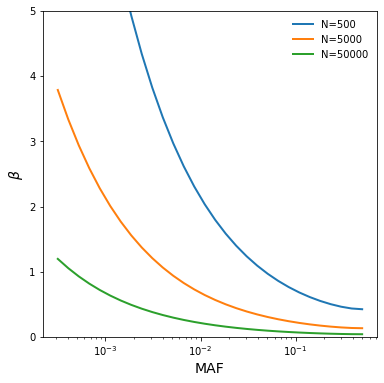

In [2]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ns = [500, 5000, 50000]
ps = np.logspace(-3.5, np.log10(0.5), 30)

for n in ns:
    opt_betas = [GWAS_Power().quant_trait_beta_power(n=n, p=p) for p in ps]
    ax.plot(ps, opt_betas, lw=2, label=f'N={n}')

ax.set_xscale('log')
ax.set_ylim(0, 5)
# ax.set_yscale('log')
ax.legend(frameon=False)
ax.set_ylabel(r'$\beta$', fontsize=14)
ax.set_xlabel(r'MAF', fontsize=14)

Text(0.5, 0, 'MAF')

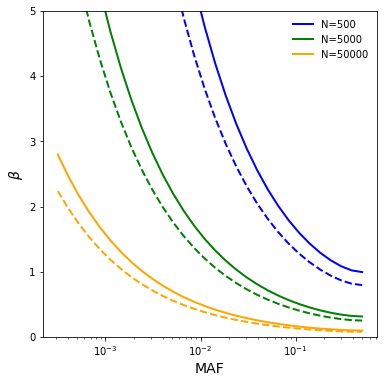

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ns = [500, 5000, 50000]
colors= ['blue', 'green', 'orange']
ps = np.logspace(-3.5, np.log10(0.5), 30)

for n,c in zip(ns, colors):
    opt_betas = [GWAS_Power().binary_trait_beta_power(n=n, p=p, power=0.8, prop_cases=0.2) for p in ps]
    opt_betas_balanced = [GWAS_Power().binary_trait_beta_power(n=n, p=p, power=0.8, prop_cases=0.5) for p in ps]
    ax.plot(ps, opt_betas, lw=2, color=c, label=f'N={n}')
    ax.plot(ps, opt_betas_balanced, lw=2, color=c, linestyle='--')

ax.set_xscale('log')
ax.set_ylim(0, 5)
ax.legend(frameon=False)
ax.set_ylabel(r'$\beta$', fontsize=14)
ax.set_xlabel(r'MAF', fontsize=14)